In [2]:
%pip install snowflake-connector-python==2.3.5

Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, './scripts')
from snowflakeDbConnector import SnowflakeDbConnector

In [32]:
client = 'colgate'
snowflake_db_connector = SnowflakeDbConnector()
database_query = f'''
        use database brands_{client};
        '''
snowflake_db_connector.getResultForQuery(database_query)

,status
0,Statement executed successfully.


In [41]:
dataframe_query = f'''
        select a.CAMPAIGN_ID,a.IMPRESSIONS,a.CLICKS,a.MATCH_TYPE,a.KEYWORDBID,
        case a.MATCH_TYPE
        when 'BROAD' then 1
        when 'PHRASE' then 0.72
        when 'EXACT' then 0.87 end,
        b.CAMPAIGN_ID,b.CLICKS,b.IMPRESSIONS
        from ams.keywords_headline_report a
        join ams.campaigns_headline_report b on a.CAMPAIGN_ID=b.CAMPAIGN_ID
        where a.KEYWORDSTATUS='Enabled'
        limit 1000 ;
        '''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

,CAMPAIGN_ID,IMPRESSIONS,CLICKS,MATCH_TYPE,KEYWORDBID,CASE A.MATCH_TYPE\n WHEN 'BROAD' THEN 1\n WHEN 'PHRASE' THEN 0.72\n WHEN 'EXACT' THEN 0.87 END,CAMPAIGN_ID,CLICKS,IMPRESSIONS
0,144221050922434038,0,0,PHRASE,2.6100000000,0.72,144221050922434038,0,0
1,144221050922434038,0,0,PHRASE,2.6100000000,0.72,144221050922434038,0,0
2,144221050922434038,0,0,PHRASE,2.6100000000,0.72,144221050922434038,0,0
3,144221050922434038,0,0,PHRASE,2.6100000000,0.72,144221050922434038,0,0
4,144221050922434038,0,0,PHRASE,2.6100000000,0.72,144221050922434038,0,0
...,...,...,...,...,...,...,...,...,...
995,144382302370524869,0,0,EXACT,1.1399900000,0.87,144382302370524869,0,0
996,144382302370524869,0,0,EXACT,1.1399900000,0.87,144382302370524869,0,0
997,144382302370524869,0,0,EXACT,1.1399900000,0.87,144382302370524869,0,0
998,144382302370524869,0,0,EXACT,1.1399900000,0.87,144382302370524869,0,0


In [24]:
# for getting numbers per match_type

dataframe_query = f'''
        select a.MATCH_TYPE,sum(a.CLICKS),sum(a.KEYWORDBID),sum(a.IMPRESSIONS)
        from ams.keywords_headline_report a
        where a.KEYWORDSTATUS='Enabled'
        and a.PROFILE_ID=1414667831379156
        group by a.MATCH_TYPE
        limit 1000 ;
        '''
        
    
# #  scaling down the values to 0-1
# dataframe_query = f'''
#         select a, c/max(c), d/max(d), e/max(e) 
#         from
#         (
#         select a.MATCH_TYPE as a,sum(a.CLICKS) as c,sum(a.KEYWORDBID) as d,sum(a.IMPRESSIONS) as e
#         from ams.keywords_headline_report a
#         where a.KEYWORDSTATUS='Enabled'
#         and a.PROFILE_ID=1414667831379156
#         group by a.MATCH_TYPE
#         ) as src
#         group by a;
#         '''
    
    
        
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

,MATCH_TYPE,SUM(A.CLICKS),SUM(A.KEYWORDBID),SUM(A.IMPRESSIONS)
0,PHRASE,131978,21189261.2003500000,49228499
1,EXACT,112526,26004683.0981900000,27514910
2,BROAD,29849,9801353.7618300000,7705583


In [42]:
# for getting numbers per match_type

dataframe_query = f'''
        select 
        a.MATCH_TYPE,sum(a.CLICKS)/count(*),sum(a.KEYWORDBID)/count(*),sum(a.IMPRESSIONS)/count(*),count(*)
        from ams.keywords_headline_report a
        where a.KEYWORDSTATUS='Enabled'
        and a.PROFILE_ID=1414667831379156
        group by a.MATCH_TYPE
        limit 1000 ;
        '''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)
keywords_report_df2

,MATCH_TYPE,SUM(A.CLICKS)/COUNT(*),SUM(A.KEYWORDBID)/COUNT(*),SUM(A.IMPRESSIONS)/COUNT(*),COUNT(*)
0,BROAD,0.005180,1.700789467152,1.337119,5762826
1,EXACT,0.012772,2.951713342428,3.123135,8810030
2,PHRASE,0.012137,1.948565207376,4.527055,10874289


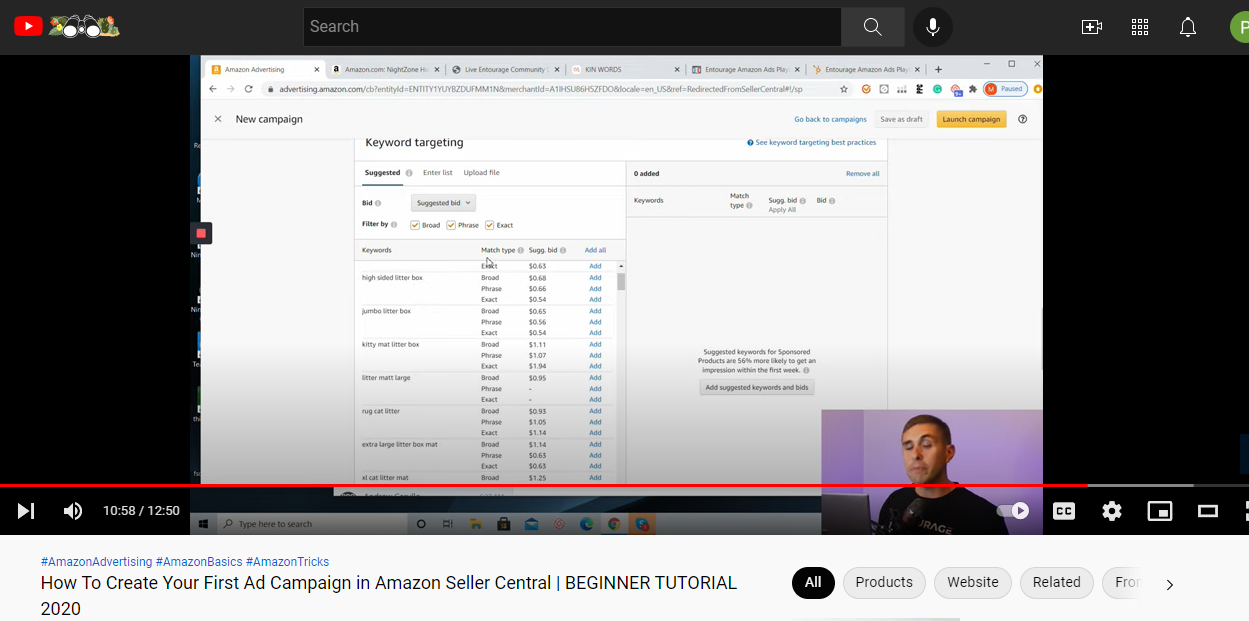


In [ ]:
# Aim for getting Search_rank for (campaign,keyword-text-,bid)table2 by (search- in table5)
# for getting numbers per match_type

# ATTENTION::: a.KEYWORDSTATUS='Enabled'; bcoz we considering only live keywords whose entry reflects real-world market effects, 
#     wherein for stopped, paused ones, they will give 0 clicks, impressions but significant bid-values..... 
#      this will deviate our analysis (outlier, not valid data)

dataframe_query = f'''
        select a.MATCH_TYPE,a.CLICKS,a.KEYWORDBID,a.IMPRESSIONS, a.KEYWORD_TEXT,
        b.SEARCH_RANK, b.SEARCH
        from ams.keywords_headline_report a
        join aramus.search_data_archive b on lower(a.KEYWORD_TEXT)=lower(b.SEARCH)
        where a.KEYWORDSTATUS='Enabled'
        and a.PROFILE_ID=1414667831379156
        order by b.SEARCH_RANK desc
        limit 1000 ;
        '''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

,MATCH_TYPE,CLICKS,KEYWORDBID,IMPRESSIONS,KEYWORD_TEXT,SEARCH_RANK,SEARCH
0,PHRASE,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
1,EXACT,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
2,EXACT,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
3,PHRASE,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
4,PHRASE,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
...,...,...,...,...,...,...,...
995,EXACT,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
996,EXACT,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
997,PHRASE,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
998,EXACT,0,0.4500000000,0,infant toothbrush,72,infant toothbrush


In [7]:
dataframe_query = f'''
        select distinct CAMPAIGN_ID,PROFILE_ID,CLIENT_ID
        from ams.keywords_headline_report a
        where 
        a.PROFILE_ID=1414667831379156
        limit 1000 ;
        '''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

,CAMPAIGN_ID,PROFILE_ID,CLIENT_ID
0,144375940572279517,1414667831379156,850
1,144176604151811220,1414667831379156,850
2,144362662416931805,1414667831379156,850
3,144119334879325302,1414667831379156,850
4,144218402871724521,1414667831379156,850
...,...,...,...
281,144292961280578087,1414667831379156,850
282,144295556514442213,1414667831379156,850
283,144348535967819632,1414667831379156,850
284,144257570019182639,1414667831379156,850


In [47]:
dataframe_query = f'''
        select distinct KEYWORD_ID,KEYWORD_TEXT,count(*)
        from ams.keywords_headline_report a
        group by keyword_id,KEYWORD_TEXT
        having count(*)<>1
        order by keyword_id,KEYWORD_TEXT
        limit 1000 ;
        '''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

,KEYWORD_ID,KEYWORD_TEXT,COUNT(*)
0,144115197796488870,+natural +bar +soap +with +shea +butter,639
1,144115197943006137,toothpaste for kids,298
2,144115198522960783,toms spearmint toothpaste,382
3,144115201522837997,colgate teeth whitening,298
4,144115205424336262,toms of maine bar soap for men,649
...,...,...,...
995,144119004372539516,teen spirit,649
996,144119004425848576,toms brand deodorant,419
997,144119015965232247,extra soft toothbrush adult,298
998,144119017279647055,adult daily natural toothpaste,384


**Since data is generated on daily, basis we have to use Distinct when supplying content for Models**

In [66]:
# dataframe_query = f'''
#         select a.MATCH_TYPE,a.CLICKS,a.KEYWORDBID,a.IMPRESSIONS, a.KEYWORD_TEXT,
#         b.SEARCH_RANK, b.SEARCH
#         from ams.keywords_headline_report a
#         join aramus.search_data_archive b on lower(a.KEYWORD_TEXT)=lower(b.SEARCH)
#         where a.KEYWORDSTATUS='Enabled'
#         and a.PROFILE_ID=1414667831379156
#         order by b.SEARCH_RANK desc
#         limit 1000 ;
#         '''
dataframe_query = f'''
    select 
    distinct 
    a.CAMPAIGN_ID,a.IMPRESSIONS,a.CLICKS,a.KEYWORDBID,
        case a.MATCH_TYPE
        when 'BROAD' then 1
        when 'PHRASE' then 0.72
        when 'EXACT' then 0.87 end as MATCH_TYPE,
        1/c.SEARCH_RANK as SEARCH_RANK,
        c.SEARCH
        from 
        (
        select  distinct CAMPAIGN_ID,IMPRESSIONS,CLICKS,KEYWORDBID,MATCH_TYPE,KEYWORD_TEXT,PROFILE_ID,KEYWORDSTATUS,
        REPORT_DATE,CREATED_TIME
        from ams.keywords_headline_report 
        where 
        (CLICKS+IMPRESSIONS)<>0
        order by CLICKS desc
        ) as a
        join 
        (
        select SEARCH,SEARCH_RANK from aramus.search_data_archive 
        where SCRAPE_DATE in (select max(SCRAPE_DATE) from aramus.search_data_archive)
        )c on (lower(a.KEYWORD_TEXT)=lower(c.SEARCH))
        where a.KEYWORDSTATUS='Enabled'
        and a.PROFILE_ID=1414667831379156
        order by CLICKS desc, SEARCH_RANK desc
        limit 5000;
        '''

keywords_report_final_sql = snowflake_db_connector.getResultForQuery(dataframe_query)
# 2 PROFILE_ID in (1414667831379156, 48152324644388)
keywords_report_final_sql

,CAMPAIGN_ID,IMPRESSIONS,CLICKS,KEYWORDBID,MATCH_TYPE,SEARCH_RANK,SEARCH
0,144387887784241991,44,2,6.5000000000,0.87,1.000000,toothpaste toddler
1,144387887784241991,44,2,6.5000000000,0.87,0.500000,toothpaste toddler
2,144387887784241991,44,2,6.5000000000,0.87,0.333333,toothpaste toddler
3,144387887784241991,44,2,6.5000000000,0.87,0.250000,toothpaste toddler
4,144387887784241991,44,2,6.5000000000,0.87,0.200000,toothpaste toddler
...,...,...,...,...,...,...,...
2875,144387887784241991,172,0,5.0000000000,0.87,0.020833,toothpaste toddler
2876,144387887784241991,22,0,5.0000000000,0.87,0.020833,toothpaste toddler
2877,144387887784241991,9,0,5.0000000000,0.87,0.020833,toothpaste toddler
2878,144387887784241991,14,0,6.5000000000,0.87,0.020833,toothpaste toddler


The issue seems to be due to date-wise data

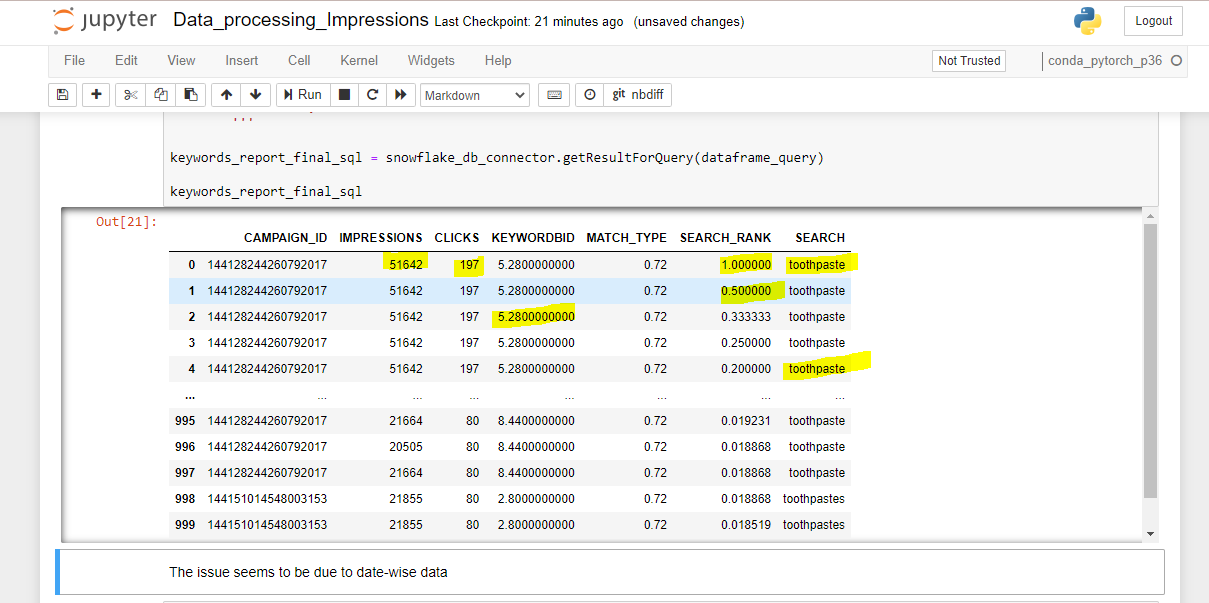

In [28]:
# USED THIS FOR checking date-between functionality it worked fine
dataframe_query_x = f'''
    select distinct SEARCH,FEED_DATE,SEARCH_RANK,SCRAPE_DATE,FEED_DATE
        from aramus.search_data_archive
        limit 1000;
        '''

# keywords_report_final_sql = snowflake_db_connector.getResultForQuery(dataframe_query)

# keywords_report_final_sql

,SEARCH,FEED_DATE,SEARCH_RANK,SCRAPE_DATE,FEED_DATE
0,alcohol free mouthwash,2019-03-30 00:49:51.136,9,2019-03-29 19:15:55,2019-03-30 00:49:51.136
1,alcohol free mouthwash,2019-03-30 00:49:51.136,11,2019-03-29 19:15:55,2019-03-30 00:49:51.136
2,alcohol free mouthwash,2019-03-30 00:49:51.136,15,2019-03-29 19:15:55,2019-03-30 00:49:51.136
3,alcohol free mouthwash,2019-03-30 00:49:51.136,41,2019-03-29 19:15:55,2019-03-30 00:49:51.136
4,alcohol free mouthwash,2019-03-30 00:49:51.136,44,2019-03-29 19:15:55,2019-03-30 00:49:51.136
...,...,...,...,...,...
995,travel toothpaste,2019-05-23 00:25:33.104,43,2019-05-22 15:43:59,2019-05-23 00:25:33.104
996,travel toothpaste,2019-05-23 00:25:33.104,45,2019-05-22 15:43:59,2019-05-23 00:25:33.104
997,travel toothpaste,2019-05-23 00:25:33.104,47,2019-05-22 15:43:59,2019-05-23 00:25:33.104
998,dental floss picks,2019-05-23 00:25:33.104,14,2019-05-22 15:51:05,2019-05-23 00:25:33.104


In [67]:
keywords_report_final_copy=keywords_report_final_sql.copy(deep='true')

In [68]:
keywords_report_final_sql=keywords_report_final_sql.drop(['CAMPAIGN_ID','CLICKS','SEARCH'], axis = 1)

In [69]:
keywords_report_final_sql

,IMPRESSIONS,KEYWORDBID,MATCH_TYPE,SEARCH_RANK
0,44,6.5000000000,0.87,1.000000
1,44,6.5000000000,0.87,0.500000
2,44,6.5000000000,0.87,0.333333
3,44,6.5000000000,0.87,0.250000
4,44,6.5000000000,0.87,0.200000
...,...,...,...,...
2875,172,5.0000000000,0.87,0.020833
2876,22,5.0000000000,0.87,0.020833
2877,9,5.0000000000,0.87,0.020833
2878,14,6.5000000000,0.87,0.020833


In [56]:
keywords_report_final_sql

,IMPRESSIONS,KEYWORDBID,MATCH_TYPE,SEARCH_RANK
0,397,5.0000000000,0.87,1.000000
1,15,6.5000000000,0.87,1.000000
2,9,6.5000000000,0.87,1.000000
3,9,6.5000000000,0.87,0.500000
4,397,5.0000000000,0.87,0.500000
...,...,...,...,...
2203,589,6.5000000000,0.87,0.020833
2204,6,5.0000000000,0.87,0.020833
2205,5,5.0000000000,0.87,0.020833
2206,402,5.0000000000,0.87,0.020833


In [73]:
def func(x):
    if x < 15:
        return "D"
    elif x < 32:
        return "C"
    elif x < 44.5:
        return "B"
    else:
        return 'A'

In [75]:
keywords_report_final_sql['Class'] = keywords_report_final_sql['IMPRESSIONS'].apply(func)

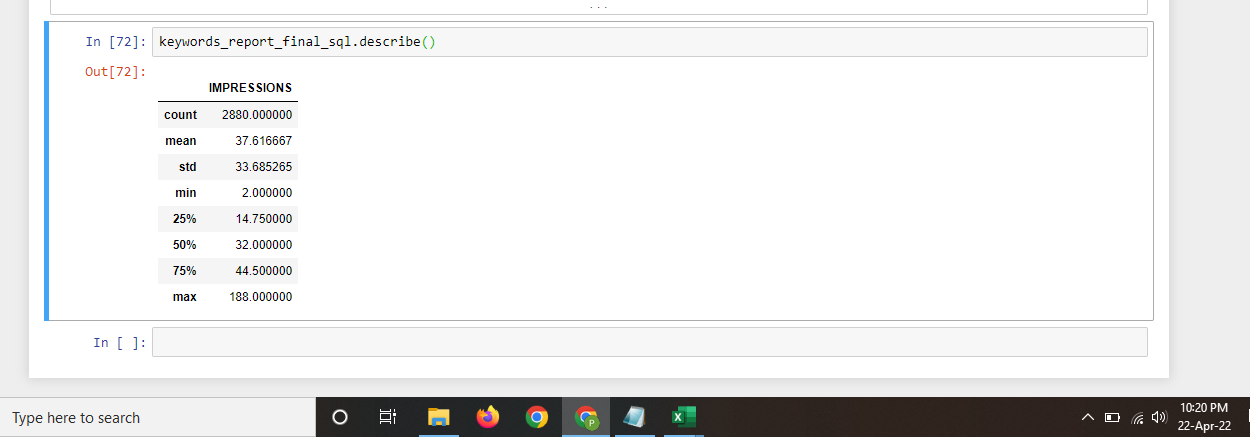

In [76]:
keywords_report_final_sql

,IMPRESSIONS,KEYWORDBID,MATCH_TYPE,SEARCH_RANK,Class
0,44,6.5000000000,0.87,1.000000,B
1,44,6.5000000000,0.87,0.500000,B
2,44,6.5000000000,0.87,0.333333,B
3,44,6.5000000000,0.87,0.250000,B
4,44,6.5000000000,0.87,0.200000,B
...,...,...,...,...,...
2875,172,5.0000000000,0.87,0.020833,A
2876,22,5.0000000000,0.87,0.020833,C
2877,9,5.0000000000,0.87,0.020833,D
2878,14,6.5000000000,0.87,0.020833,D


In [91]:
print((keywords_report_final_sql == 0).sum(axis=0))
print(keywords_report_final_sql.isnull().sum().sum())

IMPRESSIONS    0
KEYWORDBID     0
MATCH_TYPE     0
SEARCH_RANK    0
Class          0
dtype: int64
0


**DTREE on Available Data**

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

X = keywords_report_final_sql[keywords_report_final_sql.columns[1:-1]]
y = keywords_report_final_sql['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=30)

In [82]:
keywords_report_final_sql.columns[1:-1]

Index(['KEYWORDBID', 'MATCH_TYPE', 'SEARCH_RANK'], dtype='object')

In [94]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2304, 3) (576, 3) (2304,) (576,)


In [114]:
dtree=DecisionTreeClassifier(criterion='entropy',random_state=30)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=30)

In [115]:
predictions=dtree.predict(X_test)

In [116]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


print(classification_report(y_test,predictions))
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions))
print('Accuracy')
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           A       0.21      0.09      0.13       141
           B       0.32      0.46      0.38       134
           C       0.12      0.04      0.06       141
           D       0.42      0.72      0.53       160

    accuracy                           0.34       576
   macro avg       0.27      0.33      0.28       576
weighted avg       0.27      0.34      0.28       576

Confusion Matrix
[[ 13  82   4  42]
 [ 40  62   2  30]
 [  5  45   6  85]
 [  3   2  40 115]]
Accuracy
0.3402777777777778


_With entropy criteriaa_

In [105]:
from sklearn import tree
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(16,16),dpi=1024)
tree.plot_tree(dtree)
plt.show()

KeyboardInterrupt: 

In [107]:
fig = plt.figure(figsize=(400,400))
tree.plot_tree(dtree)
# fig.savefig("decistion_tree.png")

#memory ran out error

MemoryError: In RendererAgg: Out of memory

MemoryError: In RendererAgg: Out of memory

<Figure size 28800x28800 with 1 Axes>

In [117]:
dtree_GINI=DecisionTreeClassifier(criterion='gini',random_state=30)
dtree_GINI.fit(X_train,y_train)
predictions_g=dtree_GINI.predict(X_test)

print(classification_report(y_test,predictions_g))
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions_g))
print('Accuracy')
print(accuracy_score(y_test,predictions_g))

              precision    recall  f1-score   support

           A       0.21      0.09      0.13       141
           B       0.32      0.46      0.38       134
           C       0.12      0.04      0.06       141
           D       0.42      0.72      0.53       160

    accuracy                           0.34       576
   macro avg       0.27      0.33      0.28       576
weighted avg       0.27      0.34      0.28       576

Confusion Matrix
[[ 13  82   4  42]
 [ 40  62   2  30]
 [  5  45   6  85]
 [  3   2  40 115]]
Accuracy
0.3402777777777778


CAN USE ENTROPY FEATURE IMPORTANCE METRICS TO CHOOSE IMP FEATURES TO BE USED IN DTREE


import heapq 

feature_imp=dtree_Entropy.feature_importances_ 

print(feature_imp) 

print(len(feature_imp)) 

_**RANDOM FOREST**_

In [118]:
from sklearn.ensemble import RandomForestClassifier

ImportError: /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/ensemble/_gradient_boosting.cpython-36m-x86_64-linux-gnu.so: failed to map segment from shared object: Cannot allocate memory

In [ ]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)